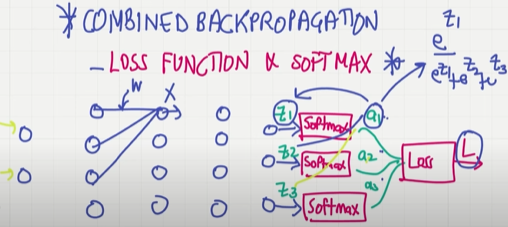

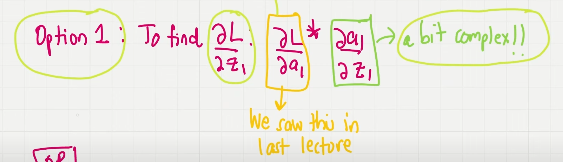

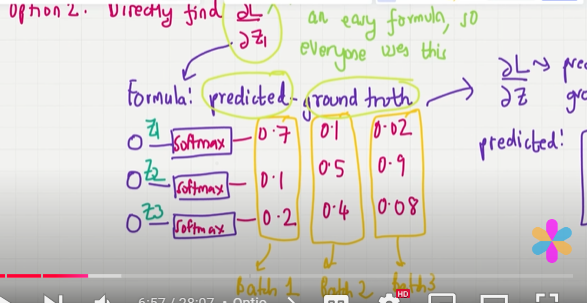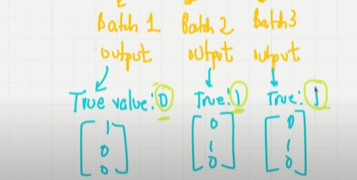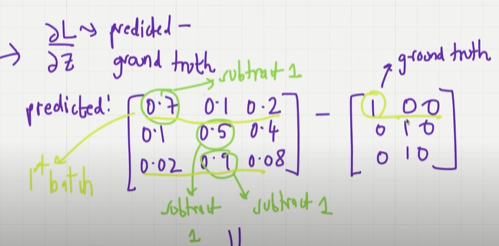

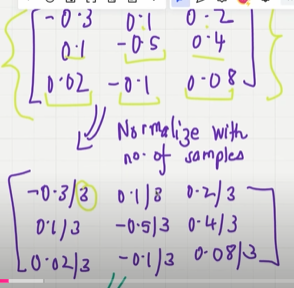

In [1]:
import numpy as np

In [2]:
# Common loss class
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = np.mean(sample_losses)
  # Return loss
  return data_loss

In [3]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    

     # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)   # dvalues , dvalues: The derivative of the loss with respect to the output.
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]  #np.eye() is a NumPy function that returns a 2D array representing an identity matrix.
        
        # y_true = np.eye(labels)[y_true] = 
        # [[1, 0, 0],  # index 0
        # [0, 1, 0],  # index 1
        # [0, 0, 1],  # index 2
        # [1, 0, 0]]  # index 0

        # identity_matrix = np.eye(3)
        # [[1. 0. 0.]
        # [0. 1. 0.]
        # [0. 0. 1.]]
        
        # -y_true = [[-1, 0, 0],
        #    [0, -1, 0],
        #    [0, 0, -1],
        #    [-1, 0, 0]]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Calculates the gradient of the loss with respect to the inputs.
        # -y_true represents the error between predicted and true labels.
        # dvalues represents the derivative of the loss with respect to the output.
        # Normalize gradient
        self.dinputs = self.dinputs / samples

        # self.dinputs = 
        # [[(-1/0.1), (0/0.2), (0/0.3)],
        # [(0/0.4), (-1/0.5), (0/0.6)],
        # [(0/0.7), (0/0.8), (-1/0.9)],
        # [(-1/1.0), (0/1.1), (0/1.2)]]







In [4]:
# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

In [5]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)  #dvalues: The derivative of the loss with respect to the output.
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1

        # dinputs = [[-10,  0,  0],
        #    [ 0, -2,  0],
        #    [ 0,  0, -1.11],
        #    [-10,  0,  0]]
        #     y_true = [0, 1, 2, 0]
        #     samples = 4

        # dinputs = [[-11,  0,  0],
        #    [ 0, -3,  0],
        #    [ 0,  0, -2.11],
        #    [-11,  0,  0]]

        # Normalize gradient
        self.dinputs = self.dinputs / samples


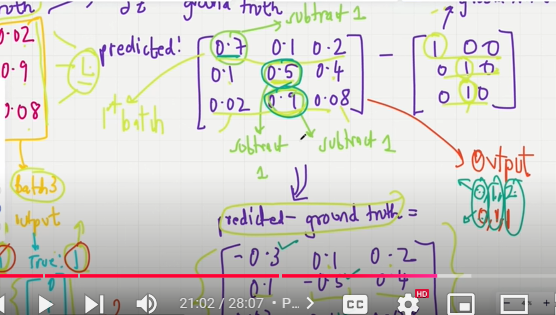

In [6]:
softmax_outputs = np.array([[0.7, 0.1, 0.2],
 [0.1, 0.5, 0.4],
 [0.02, 0.9, 0.08]])
class_targets = np.array([0, 1, 1])
softmax_loss = Activation_Softmax_Loss_CategoricalCrossentropy()
softmax_loss.backward(softmax_outputs, class_targets)
dvalues1 = softmax_loss.dinputs
print('Gradients: combined loss and activation:')
print(dvalues1)

Gradients: combined loss and activation:
[[-0.1         0.03333333  0.06666667]
 [ 0.03333333 -0.16666667  0.13333333]
 [ 0.00666667 -0.03333333  0.02666667]]


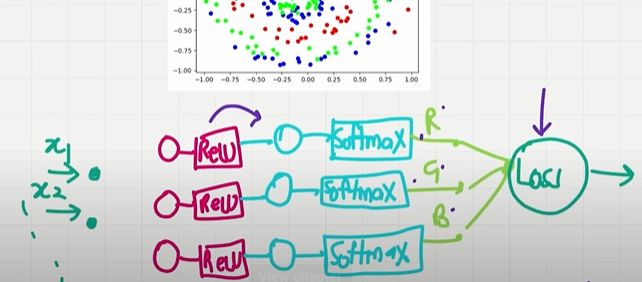


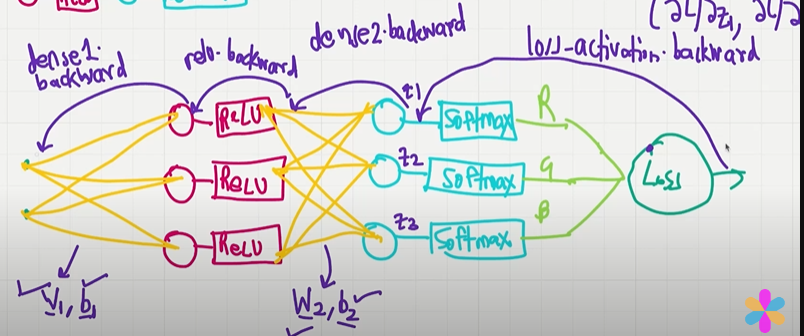

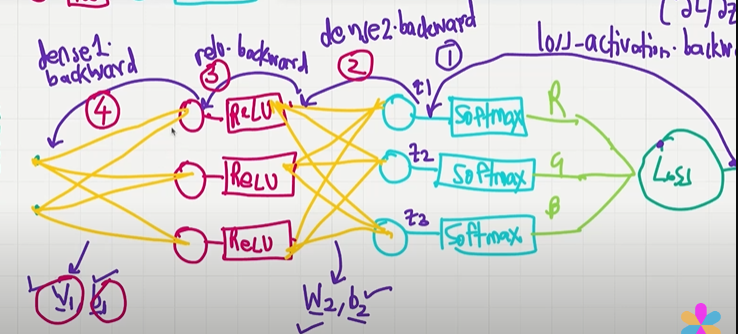

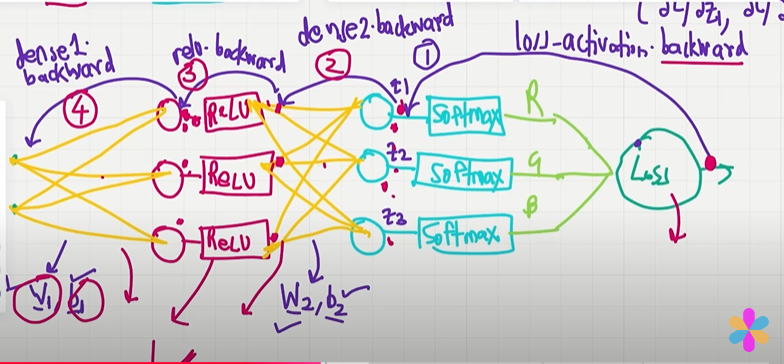

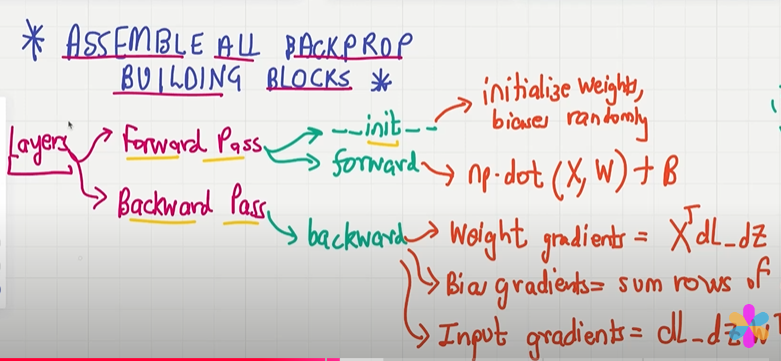


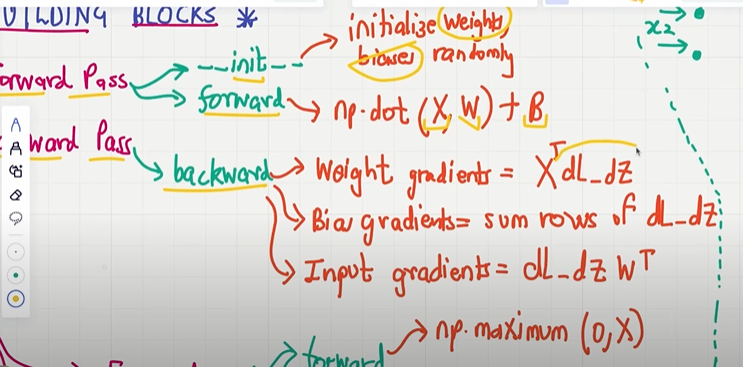

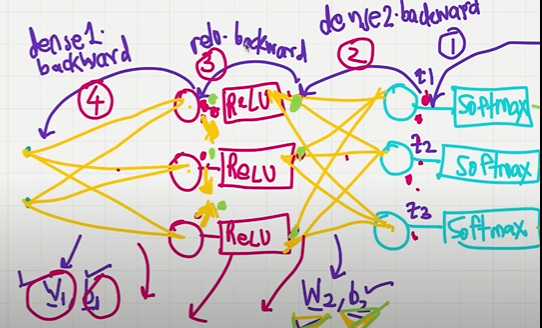

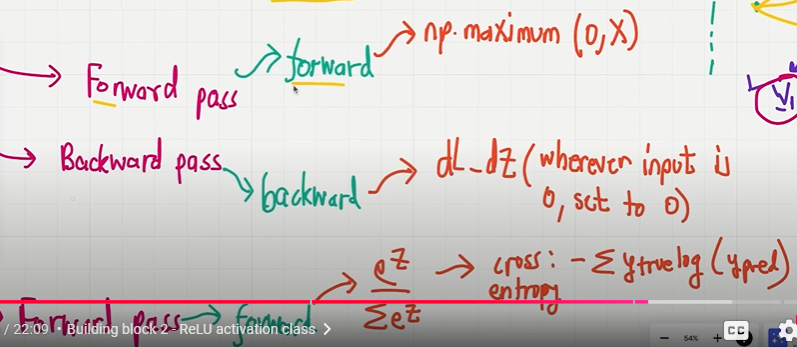

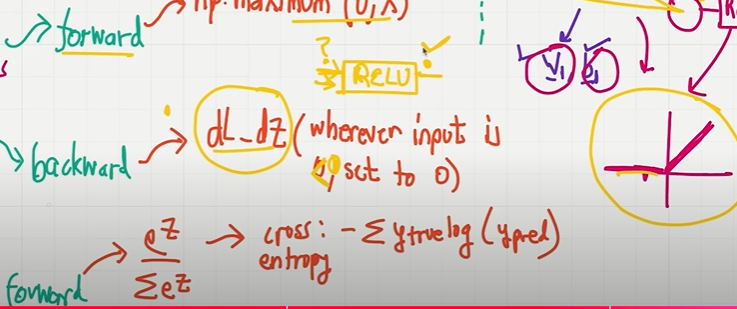

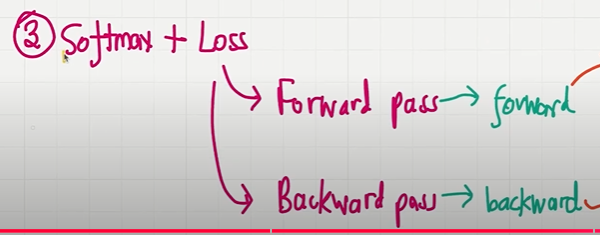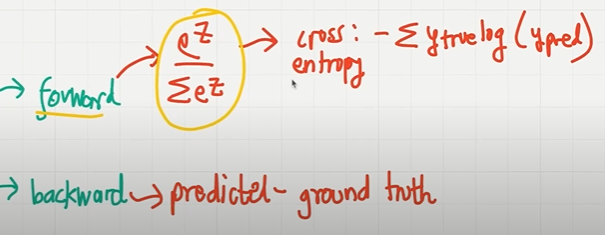

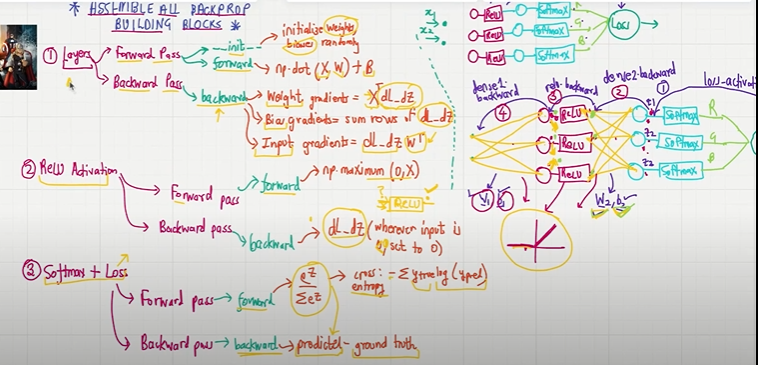

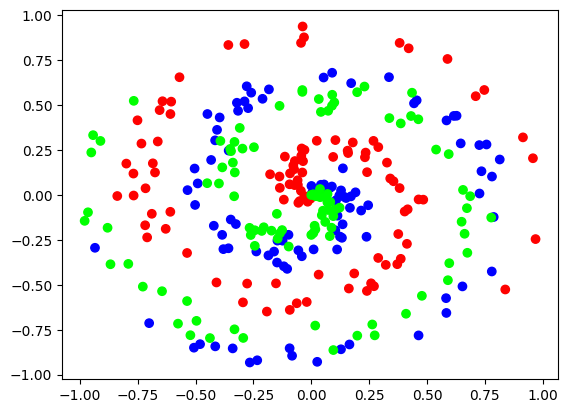

In [8]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [9]:
from Dense_Layer import Layer_Dense
from ReLU_Act import Activation_ReLU
from Softmax_Act import Activation_Softmax
from Cat_Crossentropy_Loss import Loss_Categorical_Crossentropy

In [10]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(3, 3)
# Create Softmax classifier’s combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Perform a forward pass of our training data through this layer
dense1.forward(X)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y)

# Let’s see output of the first few samples:
print(loss_activation.output[:5])
# Print loss value
print('loss:', loss)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
 y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
# Print accuracy
print('acc:', accuracy)
# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)
# Print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.3333333  0.33333334]
 [0.3333335  0.333333   0.33333352]
 [0.33333334 0.33333334 0.33333334]]
loss: 1.0986118
acc: 0.33666666666666667
[[ 7.7209341e-05 -1.0590541e-04 -8.3512561e-05]
 [ 2.8525142e-04  6.1521474e-05 -9.9994701e-05]]
[[ 0.00036935 -0.00025332  0.00021116]]
[[ 1.0425548e-04  1.5916037e-05 -1.2017150e-04]
 [-4.9149978e-05  1.9419583e-04 -1.4504585e-04]
 [ 3.6147623e-05  1.0825427e-04 -1.4440189e-04]]
[[ 1.0384247e-05 -1.0518939e-05  3.9814040e-08]]
